# Twins data experiments
This file contains experiments and plotting code for the Twins data set. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from CEVAE import *
from cevaetools import *
%load_ext autoreload
%autoreload 2

In [2]:
twins_t = pd.read_csv("data/Twins/twin_pairs_T_3years_samesex.csv")
twins_x = pd.read_csv("data/Twins/twin_pairs_X_3years_samesex.csv")
twins_y = pd.read_csv("data/Twins/twin_pairs_Y_3years_samesex.csv")

## A new bootstrap sampler

In [16]:
twins_chosen = (twins_t.dbirwt_0 < 2000) & (twins_t.dbirwt_1 < 2000)
X = twins_x.copy()[twins_chosen]
X.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'gestat10', 'infant_id_0', 'infant_id_1',
               'bord_0','bord_1','data_year'], inplace=True)
X.fillna(value=X.mean(), inplace=True)

z = twins_x[['gestat10']].copy()[twins_chosen]
z.columns = ['z']

y = twins_y.iloc[:,1:][twins_chosen].to_numpy()
true_py_dot = y.mean(0)

def sample_df(n,X,z,y,w0,wh,error):
    
    proto_proxy = pd.get_dummies(z['z'])
    proxy1 = ((np.random.random((proto_proxy.shape)) < error) + proto_proxy)%2
    proxy2 = ((np.random.random((proto_proxy.shape)) < error) + proto_proxy)%2
    proxy3 = ((np.random.random((proto_proxy.shape)) < error) + proto_proxy)%2
    proxies = pd.concat([proxy1, proxy2, proxy3], 1)
    proxies.columns = ['x'+str(i) for i in range(30)]
    
    t = (np.random.rand(X.shape[0]) < sigmoid(np.sum(w0*X,1) + wh*(z.squeeze()/10-0.1))).astype(int)
    t = pd.DataFrame(t, index=proxies.index, columns=['t'])
    yf = (pd.get_dummies(t['t']).to_numpy() * twins_y.iloc[:,1:][twins_chosen].to_numpy()).sum(1)
    yf = pd.DataFrame(yf, index=proxies.index, columns=['y'])
    ycf = ((1-pd.get_dummies(t).to_numpy()) * twins_y.iloc[:,1:][twins_chosen].to_numpy()).sum(1)
    
    df = pd.concat([proxies, z, t, yf],1)
    
    return df.sample(n, replace=True)

def sigmoid(x):
    return 1/(1+np.exp(-x))

In [17]:
sample_df(10,X,z,y,w0,wh,0.2)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x23,x24,x25,x26,x27,x28,x29,z,t,y
62174,0,0,0,1,1,0,0,0,1,0,...,1,0,0,0,0,0,1,4,0,0.0
60765,0,1,0,0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,2,1,1.0
49828,0,0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0.0
52057,0,0,1,1,0,0,1,0,0,0,...,1,0,0,1,0,0,0,4,0,0.0
70227,0,0,0,1,1,0,0,0,0,0,...,1,1,0,0,0,0,0,4,0,0.0
20480,0,0,1,0,0,0,0,1,1,0,...,0,1,0,1,0,0,0,4,0,0.0
51336,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,4,0,1.0
67517,1,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,3,1,0.0
18582,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,1,1,0,4,0,0.0
36611,1,0,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,3,0,0.0


### Generate and save data generating parameters

In [41]:
main_folder = "twinsdata"

In [32]:
#Choose the t
#w0 = np.random.randn(46)*0.1
#wh = np.random.randn(1)*0.1+5
#error = 0.2
sub_folder_params = "genparams"
#save_dataparameters([w0, wh, error], main_folder, sub_folder_params)

Creation of the directory './data/twinsdata/genparams2/ failed. Trying to empty the same folder.


In [42]:
[w0, wh, error] = load_dataparameters(main_folder, sub_folder_params)

# Run model for data sizes 1000... 30000

In [129]:
# Generate data sets
sub_folder_data = "samplesize1000to30000"
datasize = [1000,2000,5000,10000,30000,50000]
dataparameters = [[num_samples,X,z,y,w0,wh,error] for num_samples in datasize]
generate_df = sample_df
param_times=10
data_labels = list(map(str, datasize))

In [130]:
dfs, datasets = create_dfs_datasets(generate_df, dataparameters, param_times=10, repeat=False, 
                    main_folder=main_folder, sub_folder=sub_folder_data, labels=data_labels)

In [150]:
dfs, datasets = load_dfs(main_folder, sub_folder_data, param_times)

In [151]:
BATCH_SIZE = 500
track_function = lambda model: estimate_model_py_dot(model, 200000)
true_value = true_py_dot
device = 'cpu'
num_epochs = 1000
lr_start=0.004
lr_end=0.0002
z_dim=20
p_y_zt_nn_layers=3
p_y_zt_nn_width=30
p_t_z_nn_layers=3
p_t_z_nn_width=30
p_x_z_nn_layers=3
p_x_z_nn_width=50
q_z_nn_layers=3
q_z_nn_width=50
t_mode=2
y_mode=2
x_mode=np.array([2]*30)
x_dim = len(x_mode)
ty_separate_enc=True
z_mode=0
x_loss_scaling=1
labels = data_labels
common_stds=False
collect_params = 2

train_arguments = [num_epochs, lr_start, lr_end, x_dim, z_dim,
                p_y_zt_nn_layers, p_y_zt_nn_width, 
                p_t_z_nn_layers, p_t_z_nn_width,
                p_x_z_nn_layers, p_x_z_nn_width,
                q_z_nn_layers, q_z_nn_width, t_mode, y_mode,
                x_mode, ty_separate_enc, z_mode, x_loss_scaling, common_stds, collect_params]

sub_folder_model = "samplesize1000to30000_model_zdim20"

In [1]:
# Run the model
models, losses = run_model_for_predef_datasets(datasets, param_times, main_folder, sub_folder_model, 
                                               BATCH_SIZE, track_function, true_value, 
                                               device, train_arguments, labels, data_labels)

In [142]:
models, losses = load_models_losses(main_folder, sub_folder_model, train_arguments[:-1], labels, device)

In [152]:
pydot1 = np.zeros((param_times, len(labels)))
pydot0 = np.zeros((param_times, len(labels)))
for i,label in enumerate(map(str,labels)):
    print(label)
    for j in range(param_times):
        py_dot = estimate_model_py_dot(models[label][j],n=10000)
        pydot1[j,i] = py_dot[1,1]
        pydot0[j,i] = py_dot[0,1]

1000
2000
5000
10000
30000


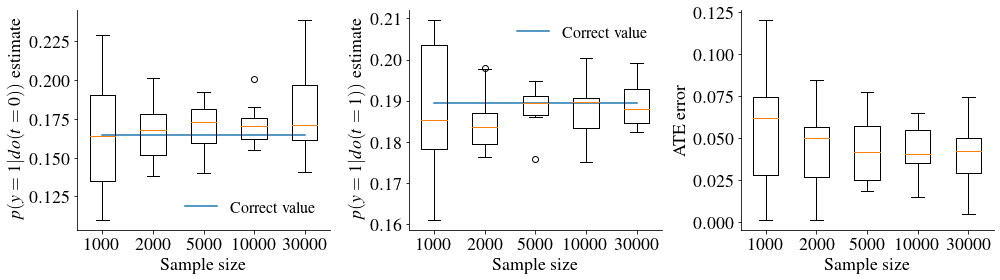

In [178]:
fig, ax = plt.subplots(1,3,figsize=(14,4))

ax[0].plot([1,5],[true_py_dot[1]]*2)
ax[0].boxplot(pydot1)

ax[1].plot([1,5],[true_py_dot[0]]*2)
ax[1].boxplot(pydot0)

ax[2].boxplot(np.abs((pydot1-pydot0)-np.abs(true_py_dot[1]-true_py_dot[0])))

for i in range(2):
    ax[i].legend(["Correct value"], frameon=False, fontsize=16)

for i in range(3):
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["top"].set_visible(False)
    ax[i].set_xticklabels(labels, fontsize=18, rotation=0)
    ax[i].tick_params(axis='y', which='major', labelsize=18, rotation=0)
    ax[i].set_xlabel("Sample size", fontsize=18)
ax[0].set_ylabel("$p(y=1|do(t=0))$ estimate", fontsize=18)
ax[1].set_ylabel("$p(y=1|do(t=1))$ estimate", fontsize=18)
ax[2].set_ylabel("ATE error", fontsize=18)
plt.tight_layout()

# Test with 50000 data points, one data set

In [239]:
sub_folder_data2 = "samplesize50000"
datasize = [50000]
dataparameters = [[num_samples,X,z,y,w0,wh,error] for num_samples in datasize]
generate_df = sample_df
param_times=10
data_labels = list(map(str, datasize))
dfs, datasets = create_dfs_datasets(generate_df, dataparameters, param_times=param_times, repeat=True, 
                    main_folder=main_folder, sub_folder=sub_folder_data, labels=data_labels)

In [2]:
dfs, datasets = load_dfs(main_folder, sub_folder_data2, param_times)

In [242]:
BATCH_SIZE = 500
track_function = lambda model: estimate_model_py_dot(model, 200000)
true_value = true_py_dot
device = 'cpu'
num_epochs = 2000
lr_start=0.004
lr_end=0.0002
z_dim=20
p_y_zt_nn_layers=3
p_y_zt_nn_width=30
p_t_z_nn_layers=3
p_t_z_nn_width=30
p_x_z_nn_layers=3
p_x_z_nn_width=50
q_z_nn_layers=3
q_z_nn_width=50
t_mode=2
y_mode=2
x_mode=np.array([2]*30)
x_dim = len(x_mode)
ty_separate_enc=True
z_mode=0
x_loss_scaling=1
labels = data_labels
common_stds=False
collect_params = 2

train_arguments = [num_epochs, lr_start, lr_end, x_dim, z_dim,
                p_y_zt_nn_layers, p_y_zt_nn_width, 
                p_t_z_nn_layers, p_t_z_nn_width,
                p_x_z_nn_layers, p_x_z_nn_width,
                q_z_nn_layers, q_z_nn_width, t_mode, y_mode,
                x_mode, ty_separate_enc, z_mode, x_loss_scaling, common_stds, collect_params]

sub_folder_model = "samplesize50000_model_zdim20"

In [3]:
# Run the model
models, losses = run_model_for_predef_datasets(datasets, param_times, main_folder, sub_folder_model, 
                                               BATCH_SIZE, track_function, true_value, 
                                               device, train_arguments, labels[-1:], data_labels[-1:])

In [243]:
models, losses = load_models_losses(main_folder, sub_folder_model, train_arguments[:-1], labels, device)
pydotests = load_saved_params(main_folder, sub_folder_model, labels)

In [244]:
pydot1_final = np.zeros((10,1))
pydot0_final = np.zeros((10,1))
for i,label in enumerate(map(str,['50000'])):
    print(label)
    for j in range(10):
        py_dot = estimate_model_py_dot(models[label][j],n=10000)
        pydot1_final[j,i] = py_dot[1,1]
        pydot0_final[j,i] = py_dot[0,1]

50000


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


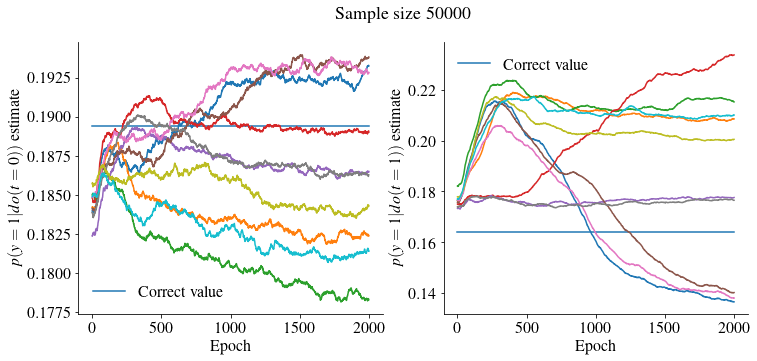

In [101]:
from scipy.ndimage.filters import uniform_filter1d
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].plot([0,2000],[true_py_dot[0],true_py_dot[0]])
ax[1].plot([0,2000],[true_py_dot[1],true_py_dot[1]])
for j in range(10):
    ax[0].plot(uniform_filter1d(np.array([pydotests['50000'][j][i][0,1]\
                            for i in range(num_epochs)]), size=100),color='C'+str(j))
    ax[1].plot(uniform_filter1d(np.array([pydotests['50000'][j][i][1,1]\
                            for i in range(num_epochs)]), size=100),color='C'+str(j))
ax[0].set_ylabel("$p(y=1|do(t=0))$ estimate", fontsize=16)
ax[1].set_ylabel("$p(y=1|do(t=1))$ estimate", fontsize=16)
for i in range(2):
    ax[i].set_xlabel("Epoch", fontsize=16)
    ax[i].legend(["Correct value"], frameon=False, fontsize=16)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["top"].set_visible(False)
    ax[i].tick_params(axis='x', which='major',labelsize=16)
    ax[i].tick_params(axis='y', which='major',labelsize=16)
plt.suptitle("Sample size 50000", fontsize=18)

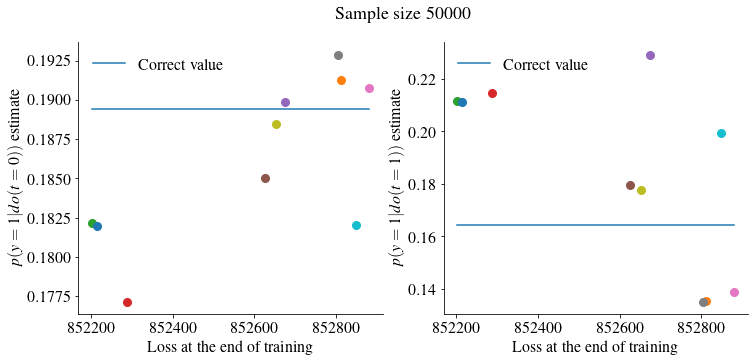

In [246]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
final_losses = [sum(losses['50000'][i]['total'][-100:])/100 for i in range(10)]

ax[0].plot([min(final_losses), max(final_losses)], [true_py_dot[0], true_py_dot[0]])
for i in range(10):
    ax[0].plot([final_losses[i]],[pydot0_final[i]],'o', markersize=8)

ax[1].plot([min(final_losses), max(final_losses)], [true_py_dot[1], true_py_dot[1]])
for i in range(10):
    ax[1].plot([final_losses[i]],[pydot1_final[i]],'o', markersize=8)

ax[0].set_ylabel("$p(y=1|do(t=0))$ estimate", fontsize=16)
ax[1].set_ylabel("$p(y=1|do(t=1))$ estimate", fontsize=16)
for i in range(2):
    ax[i].set_xlabel("Loss at the end of training", fontsize=16)
    ax[i].legend(["Correct value"], frameon=False, fontsize=16)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["top"].set_visible(False)
    ax[i].tick_params(axis='x', which='major',labelsize=16)
    ax[i].tick_params(axis='y', which='major',labelsize=16)
plt.suptitle("Sample size 50000", fontsize=18)

# Test with 10000 data points, one data set

In [256]:
sub_folder_data = "samplesize10000"
datasize = [10000]
dataparameters = [[num_samples,X,z,y,w0,wh,error] for num_samples in datasize]
generate_df = sample_df
param_times=10
data_labels = list(map(str, datasize))
dfs, datasets = create_dfs_datasets(generate_df, dataparameters, param_times=param_times, repeat=True, 
                    main_folder=main_folder, sub_folder=sub_folder_data, labels=data_labels)

In [258]:
BATCH_SIZE = 500
track_function = lambda model: estimate_model_py_dot(model, 200000)
true_value = true_py_dot
device = 'cpu'
num_epochs = 2000
lr_start=0.004
lr_end=0.0002
z_dim=20
p_y_zt_nn_layers=3
p_y_zt_nn_width=30
p_t_z_nn_layers=3
p_t_z_nn_width=30
p_x_z_nn_layers=3
p_x_z_nn_width=50
q_z_nn_layers=3
q_z_nn_width=50
t_mode=2
y_mode=2
x_mode=np.array([2]*30)
x_dim = len(x_mode)
ty_separate_enc=True
z_mode=0
x_loss_scaling=1
labels = data_labels
common_stds=False
collect_params = 2

train_arguments = [num_epochs, lr_start, lr_end, x_dim, z_dim,
                p_y_zt_nn_layers, p_y_zt_nn_width, 
                p_t_z_nn_layers, p_t_z_nn_width,
                p_x_z_nn_layers, p_x_z_nn_width,
                q_z_nn_layers, q_z_nn_width, t_mode, y_mode,
                x_mode, ty_separate_enc, z_mode, x_loss_scaling, common_stds, collect_params]

sub_folder_model = "samplesize10000_0_model_zdim20"

In [4]:
# Run the model
models, losses = run_model_for_predef_datasets(datasets, param_times, main_folder, sub_folder_model, 
                                               BATCH_SIZE, track_function, true_value, 
                                               device, train_arguments, labels[-1:], data_labels[-1:])

In [259]:
models, losses = load_models_losses(main_folder, sub_folder_model, train_arguments[:-1], labels, device)
pydotests = load_saved_params(main_folder, sub_folder_model, labels)

In [260]:
pydot1_final = np.zeros((10,1))
pydot0_final = np.zeros((10,1))
for i,label in enumerate(map(str,['10000'])):
    print(label)
    for j in range(10):
        py_dot = estimate_model_py_dot(models[label][j],n=10000)
        pydot1_final[j,i] = py_dot[1,1]
        pydot0_final[j,i] = py_dot[0,1]

10000


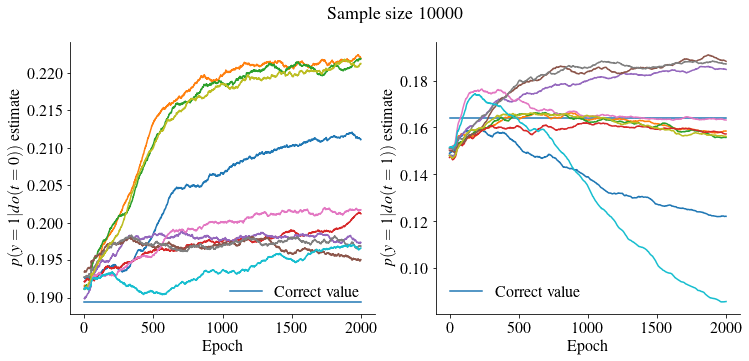

In [110]:
from scipy.ndimage.filters import uniform_filter1d
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].plot([0,2000],[true_py_dot[0],true_py_dot[0]])
ax[1].plot([0,2000],[true_py_dot[1],true_py_dot[1]])
for j in range(10):
    ax[0].plot(uniform_filter1d(np.array([pydotests['10000'][j][i][0,1]\
                            for i in range(num_epochs)]), size=100),color='C'+str(j))
    ax[1].plot(uniform_filter1d(np.array([pydotests['10000'][j][i][1,1]\
                            for i in range(num_epochs)]), size=100),color='C'+str(j))
ax[0].set_ylabel("$p(y=1|do(t=0))$ estimate", fontsize=16)
ax[1].set_ylabel("$p(y=1|do(t=1))$ estimate", fontsize=16)
for i in range(2):
    ax[i].set_xlabel("Epoch", fontsize=16)
    ax[i].legend(["Correct value"], frameon=False, fontsize=16)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["top"].set_visible(False)
    ax[i].tick_params(axis='x', which='major',labelsize=16)
    ax[i].tick_params(axis='y', which='major',labelsize=16)
plt.suptitle("Sample size 10000", fontsize=18)

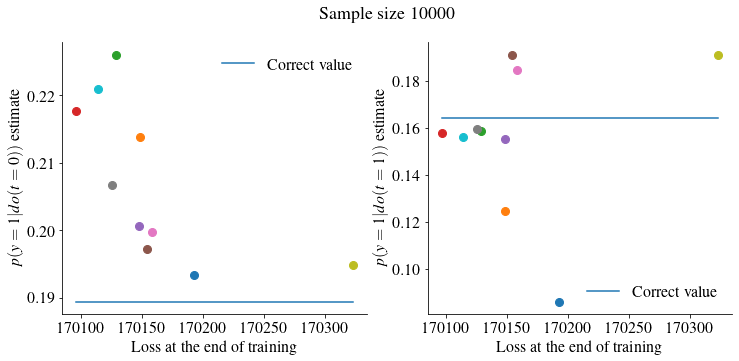

In [261]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
final_losses = [sum(losses['10000'][i]['total'][-100:])/100 for i in range(10)]

ax[0].plot([min(final_losses), max(final_losses)], [true_py_dot[0], true_py_dot[0]])
for i in range(10):
    ax[0].plot([final_losses[i]],[pydot0_final[i]],'o', markersize=8)

ax[1].plot([min(final_losses), max(final_losses)], [true_py_dot[1], true_py_dot[1]])
for i in range(10):
    ax[1].plot([final_losses[i]],[pydot1_final[i]],'o', markersize=8)

ax[0].set_ylabel("$p(y=1|do(t=0))$ estimate", fontsize=16)
ax[1].set_ylabel("$p(y=1|do(t=1))$ estimate", fontsize=16)
for i in range(2):
    ax[i].set_xlabel("Loss at the end of training", fontsize=16)
    ax[i].legend(["Correct value"], frameon=False, fontsize=16)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["top"].set_visible(False)
    ax[i].tick_params(axis='x', which='major',labelsize=16)
    ax[i].tick_params(axis='y', which='major',labelsize=16)
plt.suptitle("Sample size 10000", fontsize=18)